## Импорты

In [1]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

from math import sqrt

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
target = data['users'].copy()

data = data['users'].copy()
data = data.to_frame()
data

,users
date_time,
2011-01-01 00:00:00,16.0
2011-01-01 01:00:00,40.0
2011-01-01 02:00:00,32.0
2011-01-01 03:00:00,13.0
2011-01-01 04:00:00,1.0
...,...
2012-12-31 19:00:00,119.0
2012-12-31 20:00:00,89.0
2012-12-31 21:00:00,90.0


### Анализ временного ряда

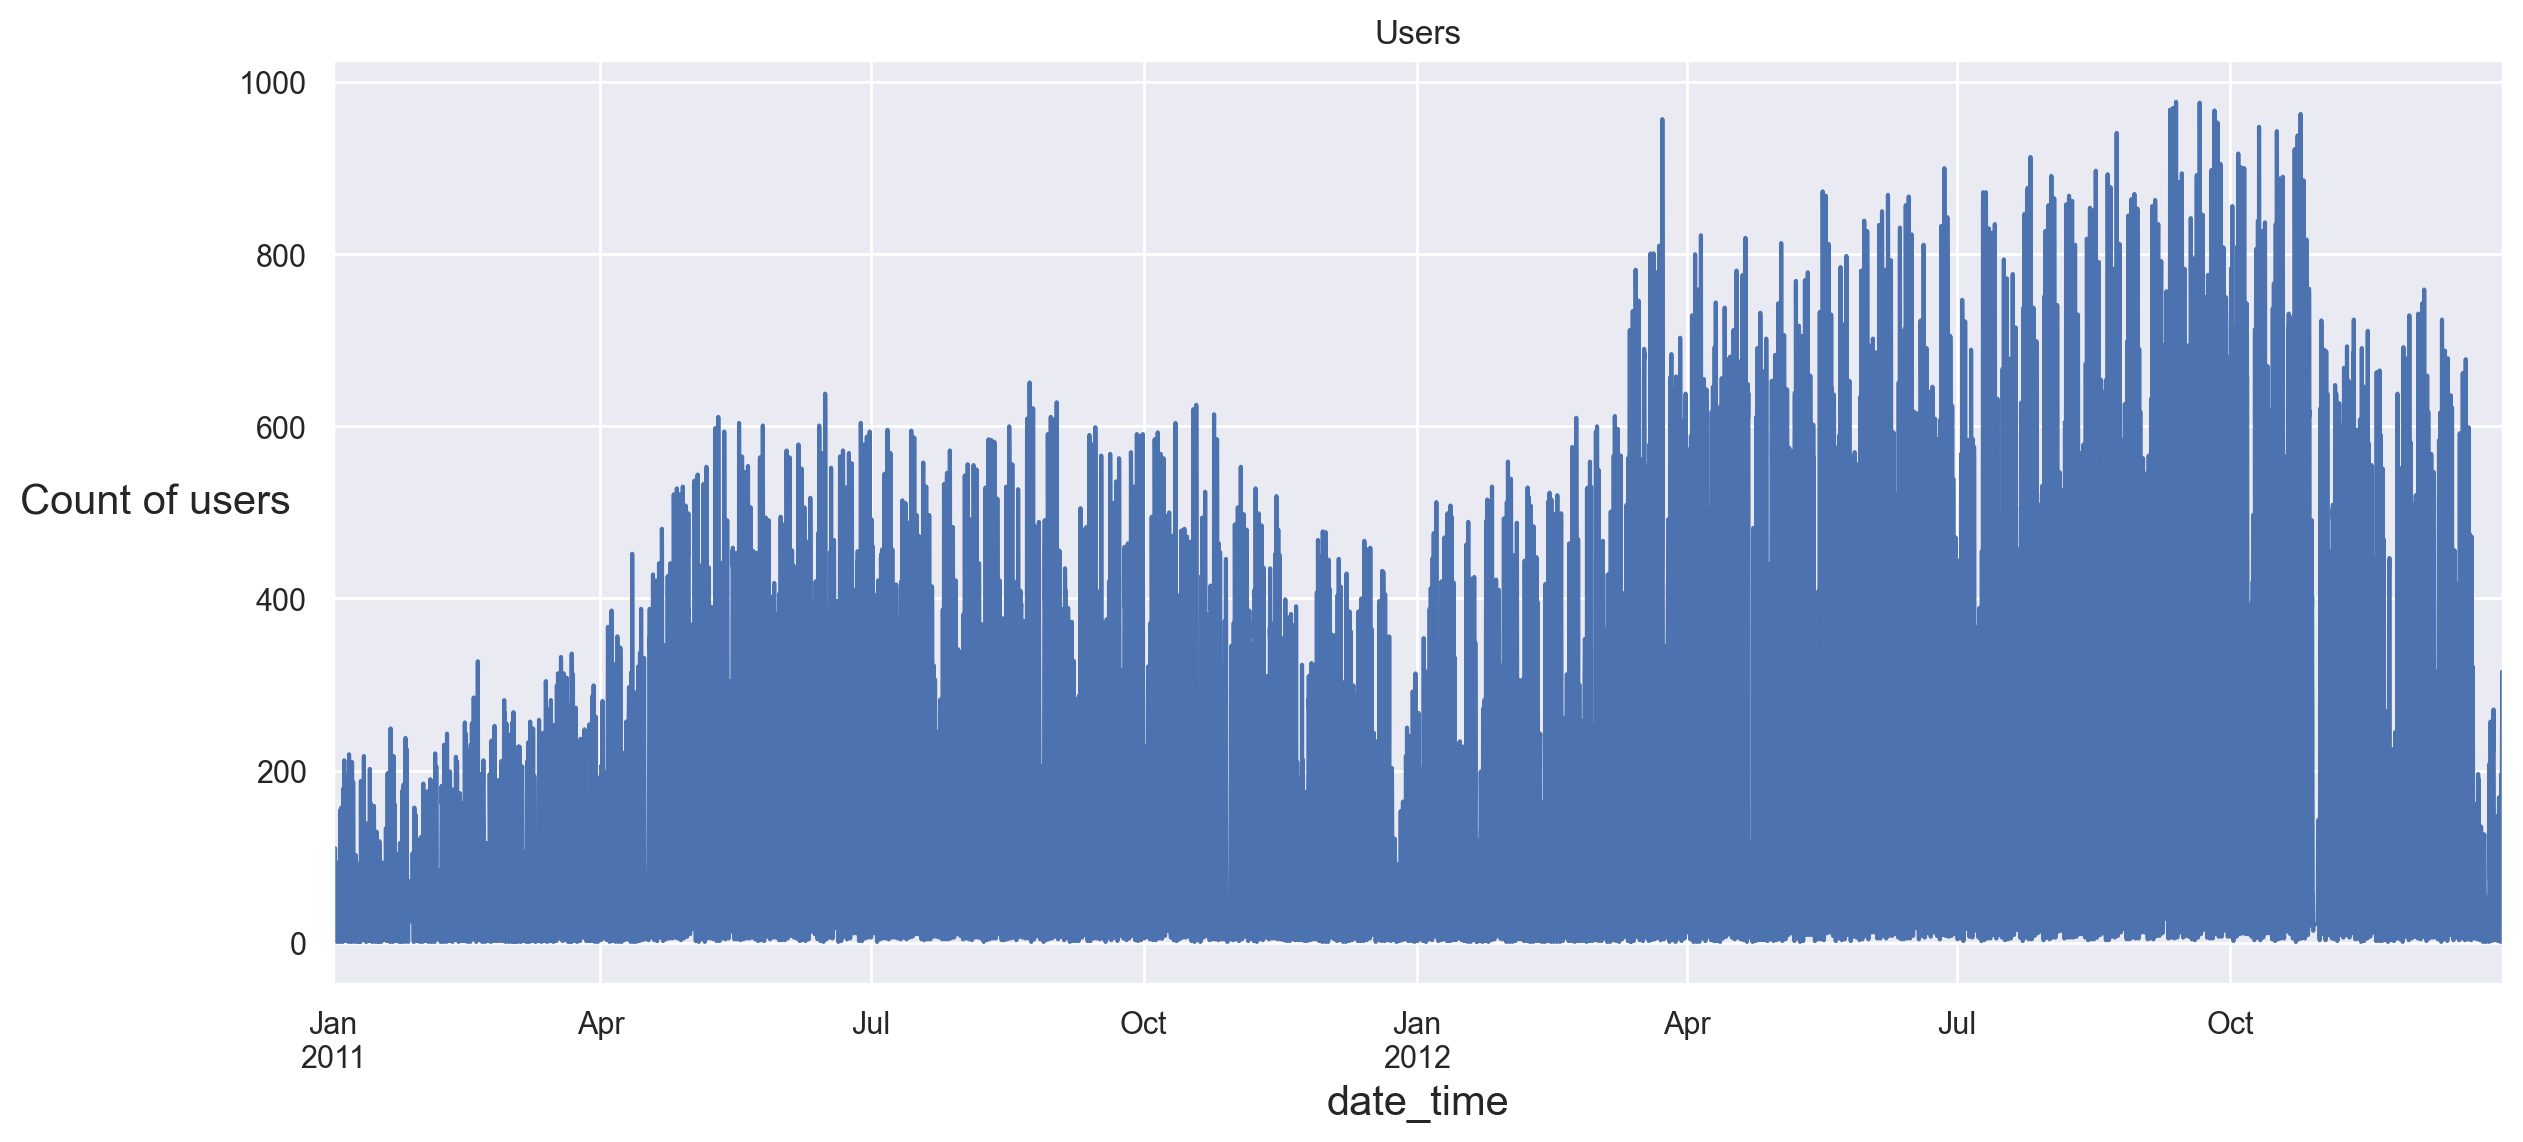

In [4]:
plt.figure(figsize=(14, 6))
plt.title('Users')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count of users', rotation=0, labelpad=30, fontsize=15)
data['users'].plot();

Исходя из этого графика, можно заметить, что наблюдается зависимость от месяца года. Даже несмотря на то, что в 2012 году в среднем больше пользователей, есть четкая пропорцианальность между месяцами каждого года.
Тогда давайте посмотрим на тренд, сезонность, случайный шум с периодом, равным 365 дням, так как эта зависимость наблюдается только за год.

In [ ]:
# посмотрим на тренд, сезонность, случайный шум
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(data[['users']], period=365)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

График сезонности показывает, что мое предположение о зависимости от месяца является верным.

### Создание новых временных признаков

In [ ]:
def make_features(X, max_lag):
    rolling_mean_size = 24

    data = X.copy()
    CAT_FEATURES = ['day', 'month', 'weekday', 'hour']

    data['rolling_mean'] = data['users'].rolling(rolling_mean_size).mean().shift(1)

    data['day'] = data.index.day
    data['month'] = data.index.month
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour

    for n in range(1, max_lag+1):
        data[f'lag_{n}'] = data['users'].shift(n)

    data.dropna(inplace=True)

    target = data['users']

    data = data.drop('users', axis=1)

    return data, target

In [7]:
X_data, y_data = make_features(data[['users']], max_lag = 24)

In [8]:
X_data

,rolling_mean,day,month,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-02 00:00:00,41.041667,2,1,6,0,39.0,28.0,34.0,36.0,37.0,...,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0,40.0,16.0
2011-01-02 01:00:00,41.083333,2,1,6,1,17.0,39.0,28.0,34.0,36.0,...,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0,40.0
2011-01-02 02:00:00,40.125000,2,1,6,2,17.0,17.0,39.0,28.0,34.0,...,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0
2011-01-02 03:00:00,39.166667,2,1,6,3,9.0,17.0,17.0,39.0,28.0,...,84.0,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0
2011-01-02 04:00:00,38.875000,2,1,6,4,6.0,9.0,17.0,17.0,39.0,...,94.0,84.0,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,109.458333,31,12,0,19,122.0,164.0,214.0,315.0,247.0,...,3.0,1.0,11.0,19.0,34.0,49.0,36.0,47.0,72.0,102.0
2012-12-31 20:00:00,110.166667,31,12,0,20,119.0,122.0,164.0,214.0,315.0,...,9.0,3.0,1.0,11.0,19.0,34.0,49.0,36.0,47.0,72.0
2012-12-31 21:00:00,110.875000,31,12,0,21,89.0,119.0,122.0,164.0,214.0,...,40.0,9.0,3.0,1.0,11.0,19.0,34.0,49.0,36.0,47.0


## Всякие функции для отрисовки результата

In [9]:
def compare_result_and_test(res, t_target):
  plt.figure(figsize=(16, 8), dpi=150)

  res['users'].plot(label='predictions', color='orange')
  t_target.plot(label='GM')

def draw_dependency(first, second, mean_accuracy, first_name, second_name):
  plt.figure(figsize=(10, 6))
  sns.lineplot(x=first[sorted_indices], y=mean_accuracy[sorted_indices], hue=second[sorted_indices])
  plt.xlabel(first_name)
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs n_estimators for different ' + second_name)
  plt.legend(title=second_name)
  plt.show()

def draw_features_importance(features, imprt):
  fig, ax = plt.subplots(figsize=(8,8))

  bars = plt.barh(features, imprt)

  plt.show()

### Предсказание с помощью градиентного бустинга (GridSearchCV)

In [10]:
params = {
    'n_estimators' : [500, 700],
    'max_depth' : [4, 8],
    'learning_rate' : [0.1],
    'loss' : ['squared_error']
}
model = GradientBoostingRegressor()

In [11]:
model_CV = GridSearchCV(
                    model,
                    param_grid = params,
                    verbose=10
                    )

In [12]:
model_CV.fit(X_data, y_data)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500
[CV 1/5; 1/4] END learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500;, score=0.920 total time=  35.2s
[CV 2/5; 1/4] START learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500
[CV 2/5; 1/4] END learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500;, score=0.932 total time=  34.7s
[CV 3/5; 1/4] START learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500
[CV 3/5; 1/4] END learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500;, score=0.945 total time=  35.0s
[CV 4/5; 1/4] START learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500
[CV 4/5; 1/4] END learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500;, score=0.953 total time=  34.2s
[CV 5/5; 1/4] START learning_rate=0.1, loss=squared_error, max_depth=4, n_estimators=500
[CV 5/5; 1/4] E

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1], 'loss': ['squared_error'],
                         'max_depth': [4, 8], 'n_estimators': [500, 700]},
             verbose=10)

In [13]:
model_CV.cv_results_

{'mean_fit_time': array([34.68589787, 48.90414357, 70.03923407, 98.49299974]),
 'std_fit_time': array([0.37849019, 0.53424807, 0.87392492, 1.2204938 ]),
 'mean_score_time': array([0.01248679, 0.01615667, 0.02365327, 0.03154783]),
 'std_score_time': array([0.00106682, 0.00120824, 0.00225538, 0.00237263]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_loss': masked_array(data=['squared_error', 'squared_error', 'squared_error',
                    'squared_error'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[4, 4, 8, 8],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[500, 700, 500, 700],
              mask=[False, False, False, False],
        fill_value='?',
             dty

### Посмотрим на графики зависимостей score от параметров: количество деревьев, максимальная глубина дерева, learning rate

Для чего нужно:
В params для GridSearch я почти на шару задала параметры для глубины деревьев, количество деревьев и шага обучения. Теперь имея на руках результаты обучения, я могу посмотреть, где accuracy более высокая, а где более низкая. Следовательно могу отбросить те параметры, на которых выдается не самый хороший результат, чтобы в дальнейшем обучение не занимало так много времени.

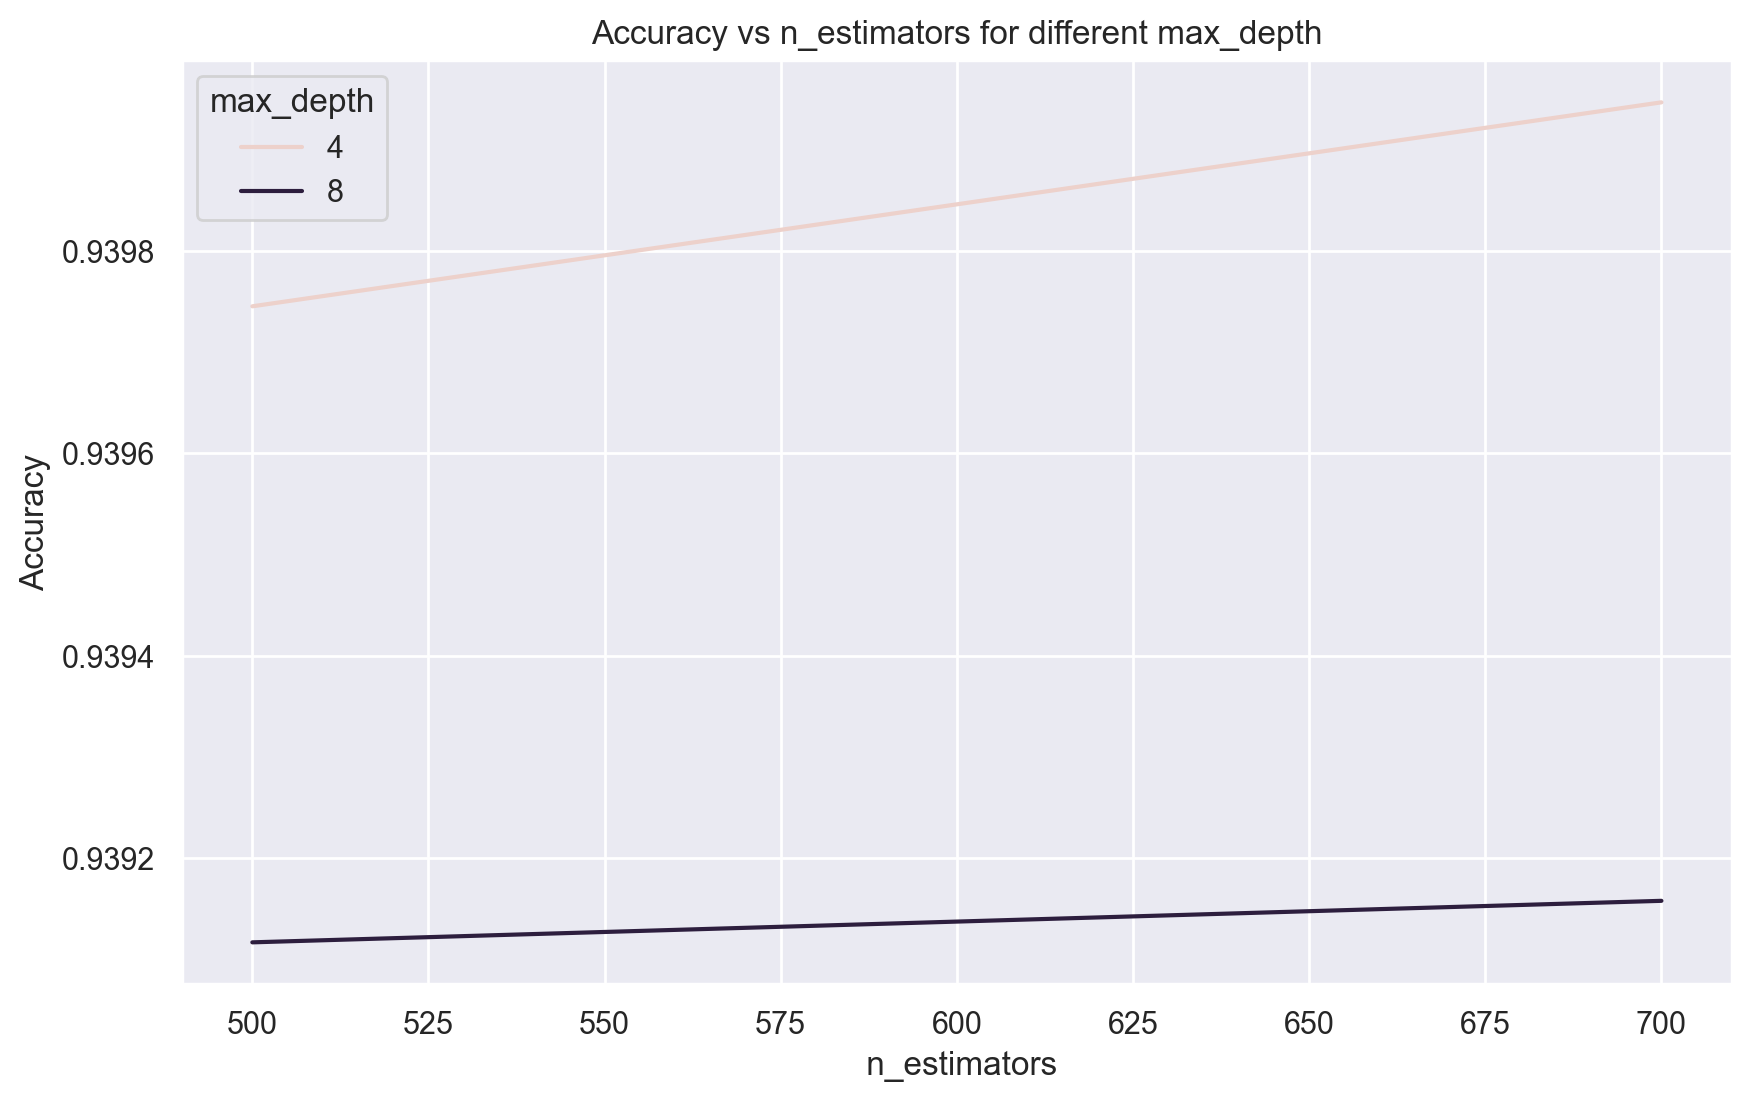

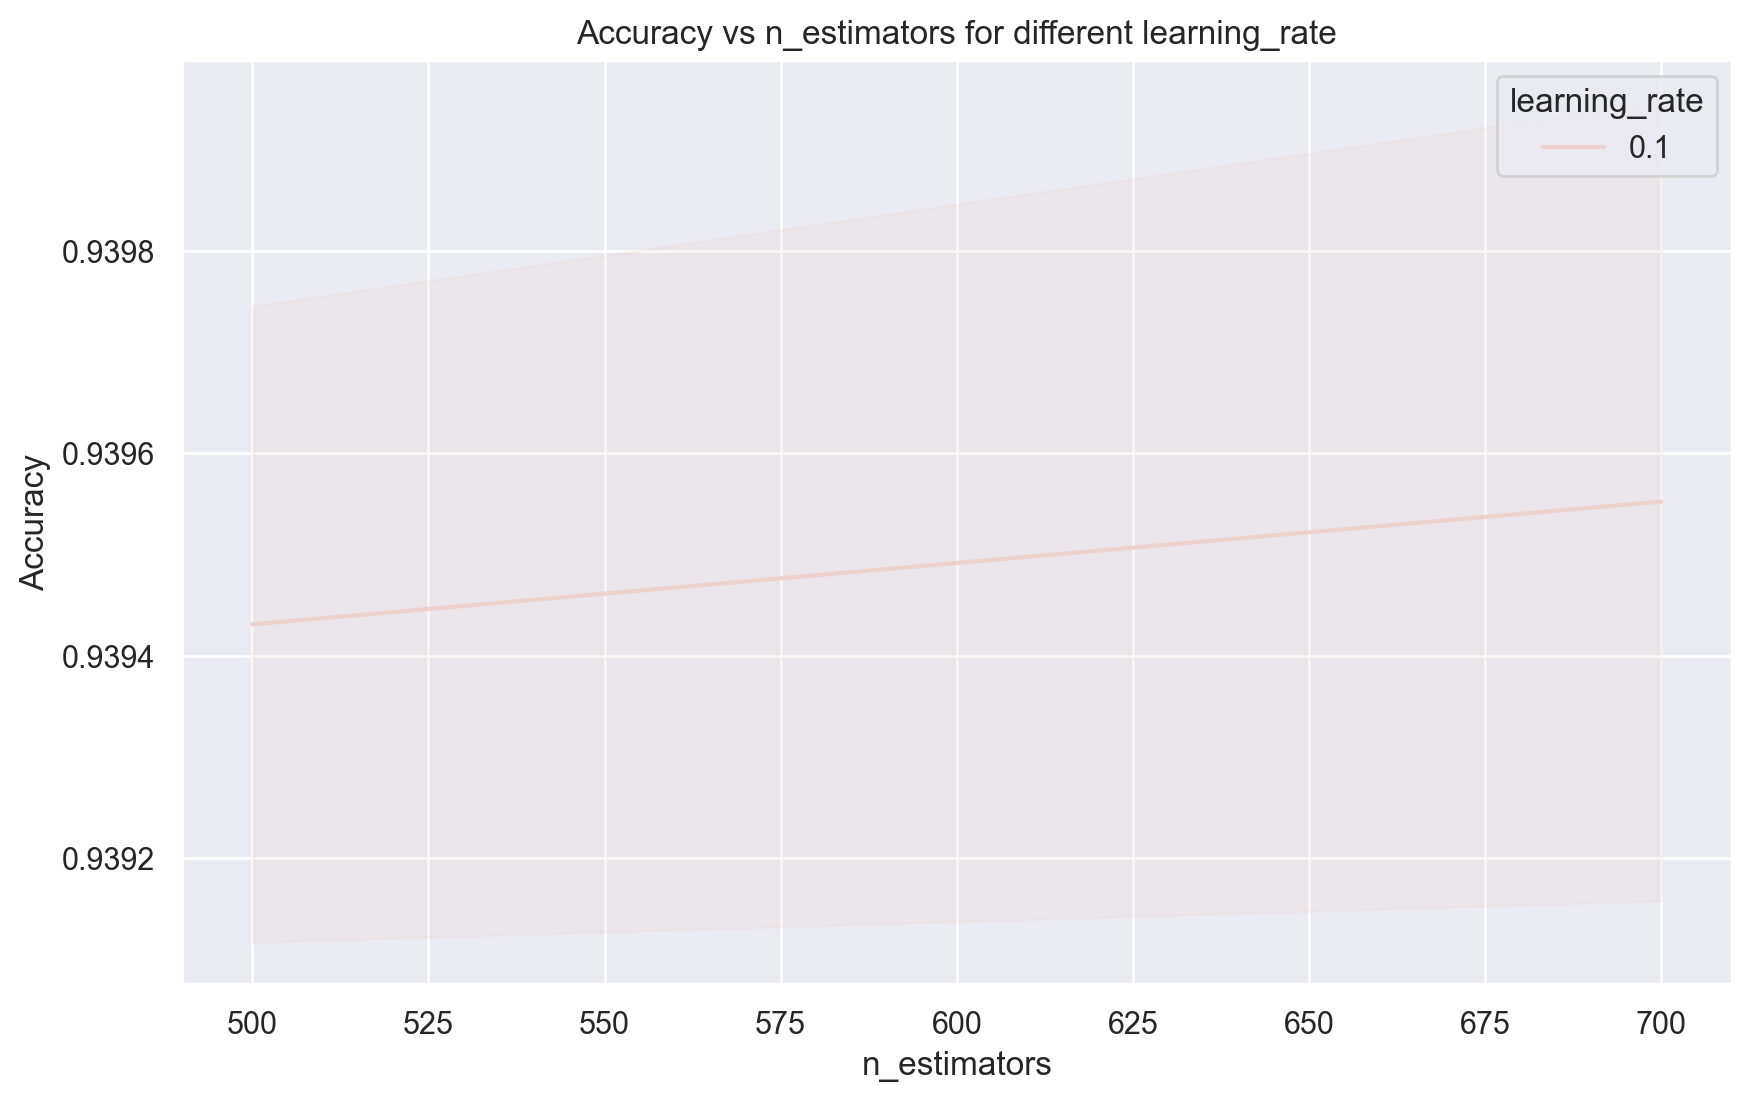

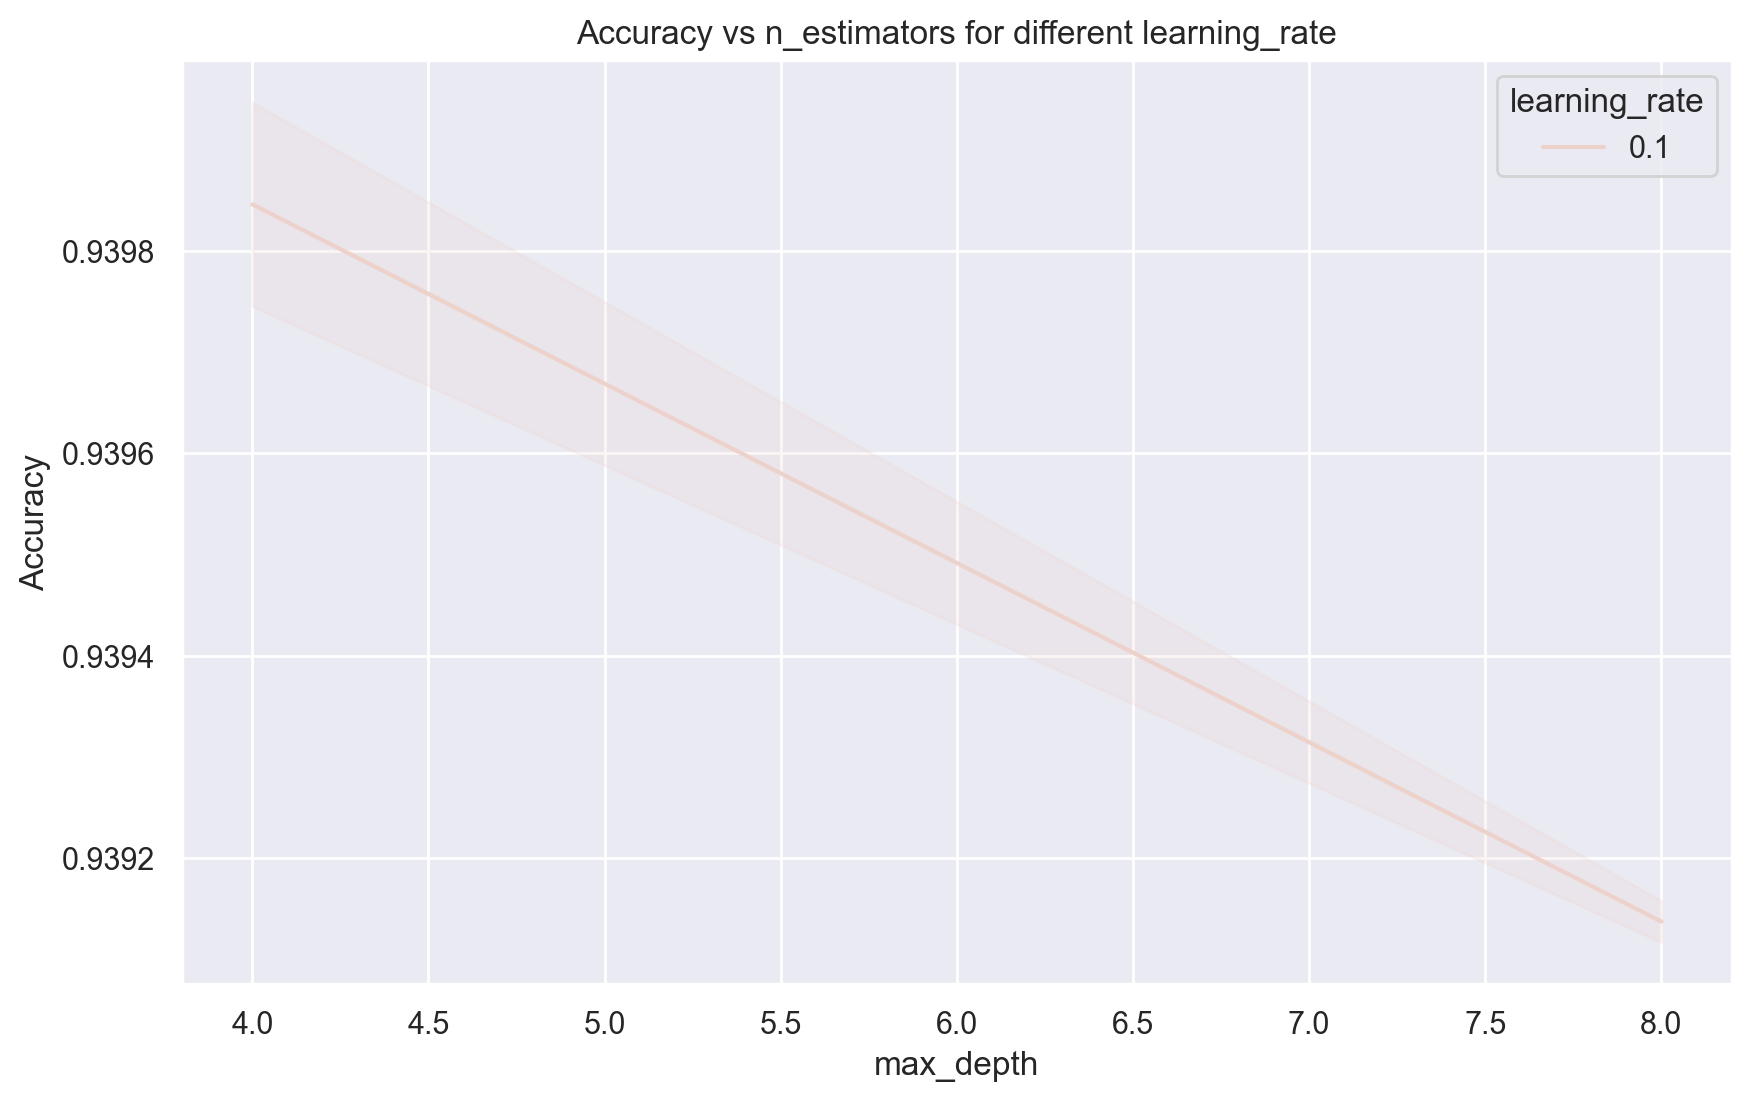

In [14]:
results = model_CV.cv_results_

# Отбор нужных столбцов для графиков
n_estimators = results['param_n_estimators'].data.astype(int)
max_depth = results['param_max_depth'].data.astype(int)
learning_rate = results['param_learning_rate'].data.astype(float)
mean_accuracy = results['mean_test_score']


# Сортировка значений гиперпараметров
sorted_indices = np.lexsort((n_estimators, max_depth, learning_rate))

# Построение графика точности от количества деревьев при разных значениях глубины деревьев
draw_dependency(n_estimators, max_depth, mean_accuracy, " n_estimators", "max_depth")

# Построение графика точности от количества деревьев при разных значениях шага обучения
draw_dependency(n_estimators, learning_rate, mean_accuracy, "n_estimators", "learning_rate")

# Построение графика точности от количества деревьев при разных значениях шага обучения
draw_dependency(max_depth, learning_rate, mean_accuracy, "max_depth", "learning_rate")



Давайте посмотрим, что нам выдает model_CV.best_estimator_



In [15]:
best_model = model_CV.best_estimator_
important_features = model_CV.best_estimator_.feature_importances_
features = train_data.columns

features_imprt = pd.DataFrame({'feats' : features, 'value_of_imp' : important_features})

draw_features_importance(features_imprt['feats'], features_imprt['value_of_imp'])

NameError: name 'train_data' is not defined

### Обучаем и тестим одну модель c лучшими параметрами, выбранные на GridSearchCV

In [ ]:
train_data, test_data, train_target, test_target = train_test_split(X_data, y_data, test_size = 0.3, shuffle=False)

one_model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=700, max_depth=4, loss='huber')

In [ ]:
one_model.fit(train_data, train_target)

#### Посмотрим на метрики

In [ ]:
results = one_model.predict(test_data)

print('RMSE', round(mean_squared_error(results, test_target) ** 0.5, 2))

print('R2 score: ', r2_score(y_pred = results, y_true = test_target))

#### Визуализация сравнения предсказаний одного лучшего GV и настояшего временного ряда

In [ ]:
result_date = test_target.reset_index()
result_date['users'] = results
result_date = result_date.set_index('date_time')

compare_result_and_test(result_date, test_target)

### Вывод из графика и метрик:

## Имплеметнация градиентного бустинга

In [ ]:
class GradientBoosting(BaseEstimator):
    def __init__(
        self,
        n_estimators=10,
        learning_rate=0.01,
        max_depth=3,
        random_state=17,
        loss_name="mse",
        debug=True,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.loss_name = loss_name
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0], 1])
        self.debug = debug

        if loss_name == "mse":
            self.objective = mean_squared_error
            self.objective_grad = self.mse_grad

        elif loss_name == "rmsle":
            self.objective = self.rmsle
            self.objective_grad = self.rmsle_grad

        self.trees_ = []

        if self.debug:
            self.residuals = []
            self.temp_pred = []

    def mse_grad(self, y, p):
        return 2 * (p - y.reshape([y.shape[0], 1])) / y.shape[0]

    def rmsle(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return np.mean(np.log((p + 1) / (y + 1)) ** 2) ** 0.5

    def rmsle_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return (1.0 / (y.shape[0] * (p + 1) * self.rmsle(y, p)) * np.log((p + 1) / (y + 1)))

    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)

        prediction = b.copy()

        for t in range(self.n_estimators):
            if t == 0:
              resid = y
            else:
              resid = -self.objective_grad(y, prediction)

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth, random_state=self.random_state
            )
            tree.fit(X, resid)
            b = tree.predict(X).reshape([X.shape[0], 1])

            if self.debug:
                self.temp_pred.append(b)
                self.residuals.append(resid)

            self.trees_.append(tree)
            prediction += self.learning_rate * b

        self.train_pred = prediction
        return self, self.temp_pred, self.residuals

    def predict(self, X):
        pred = np.ones([X.shape[0], 1]) * np.mean(self.y)
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape([X.shape[0], 1])

        return pred

###Подбираем параметры имплементрированной модели с помощью самописного GridSearchCV

In [ ]:
n_estimators = [700, 900]
max_depth = [6, 8]
learning_rate = [0.5, 0.7, 0.8]

best_RMSE = 100000

for est in n_estimators:
  for depth in max_depth:
    for lr in learning_rate:
      my_model = GradientBoosting(n_estimators=est, learning_rate=lr, max_depth=depth)
      my_model.fit(train_data, train_target.values)
      res = my_model.predict(test_data)
      rmse = round(mean_squared_error(res, test_target) ** 0.5, 2)
      print("count of estsimators: " + str(est) + ", max depth: " + str(depth) + ", learning rate:  " + str(lr) + ', RMSE: ' + str(rmse))

      if best_RMSE > rmse:
          best_est = est
          best_depth = depth
          best_lr = lr
          best_rmse = rmse


print("best rmse: " + str(best_rmse) + ", best ests: " + str(best_depth) + ", best depth: " + str(best_depth) + ", best lr: " + str(best_lr))

#### Обучаем модель с наилучшими парметрами, выбранные с помощью самописного GridSearchCV

In [ ]:
best_impl_model = GradientBoosting(n_estimators=900, learning_rate=0.8, max_depth=8)
debug_result = best_impl_model.fit(train_data, train_target.values)

#### Смотрим на метрики

In [ ]:
result_impl = best_impl_model.predict(test_data)

print('RMSE: ', round(mean_squared_error(result_impl, test_target) ** 0.5, 2))

print('R2 score: ', r2_score(y_pred = result_impl, y_true = test_target))

#### Смотрим на графики результатов имлементированного GB и target

In [ ]:
result_date_impl = test_target.reset_index()
result_date_impl['users'] = results
result_date_impl = result_date_impl.set_index('date_time')

compare_result_and_test(result_date_impl, test_target)

## Теперь давайте уберем признаки, которые не внесли никакой пользы и посмотрим на результат

In [ ]:
features_to_drop = ['lag_21', 'lag_19', 'lag_18', 'lag_17', 'lag_16', 'lag_15', 'lag_8', 'lag_7', 'lag_5', 'month', 'day', 'rolling_mean']
new_data_train = train_data.drop(features_to_drop, axis=1)
new_test_data = test_data.drop(features_to_drop, axis=1)

In [ ]:
n_estimators = [700, 900]
max_depth = [6, 8]
learning_rate = [0.5, 0.7, 0.8]

best_RMSE = 100000

for est in n_estimators:
  for depth in max_depth:
    for lr in learning_rate:
      my_model = GradientBoosting(n_estimators=est, learning_rate=lr, max_depth=depth)
      my_model.fit(new_data_train, train_target.values)
      res = my_model.predict(new_test_data)
      rmse = round(mean_squared_error(res, test_target) ** 0.5, 2)
      print("count of estsimators: " + str(est) + ", max depth: " + str(depth) + ", learning rate:  " + str(lr) + ', RMSE: ' + str(rmse))

      if best_RMSE > rmse:
          best_est = est
          best_depth = depth
          best_lr = lr
          best_rmse = rmse


print("best rmse: " + str(best_rmse) + ", best ests: " + str(best_depth) + ", best depth: " + str(best_depth) + ", best lr: " + str(best_lr))

#### Теперь проделаем ту же процедуру, что и раньше: обучим одну модель с наилучшими параметрами, посмотрим на метрики и графики тестовых и полученных данных.

In [ ]:
feat_impl_model = GradientBoosting(n_estimators=700, learning_rate=0.7, max_depth=8)
debug_result = feat_impl_model.fit(train_data, train_target.values)

In [ ]:
result_feat_impl = feat_impl_model.predict(test_data)

print('RMSE: ', round(mean_squared_error(result_feat_impl, test_target) ** 0.5, 2))

print('R2 score: ', r2_score(y_pred = result_feat_impl, y_true = test_target))

In [ ]:
result_date_feat_impl = test_target.reset_index()
result_date_feat_impl['users'] = results
result_date_feat_impl = result_date_feat_impl.set_index('date_time')

compare_result_and_test(result_date_feat_impl, test_target)

## Итог
1) Благодаря удалению признаков мне удалось улучшить результат

2) Я вообще в первый раз сталкаиваюсь с таким большим learning rate

3) Тут можно еще кучу всего сделать, но я уже не успеваю, честно говоря. Планы на будущее по этой лабораторной: PCA, feature engineering (не очень правда понятно, как здесь преобразовывать признаки), добавление в GridSearch min_samples_leaf.